# Credit Rating Study

---
embed-resources: true
---

## Introduction

In this study, we develop a model to predict a customer's credit rating based on key demographic and financial attributes. The model leverages historical credit data, including income, age, education, and marital status, to estimate an individual's creditworthiness. By analyzing these factors, we aim to provide a data-driven approach to credit scoring, reducing the bank’s reliance on third-party credit agencies. While the model offers valuable insights, it does not account for external financial behaviors, such as spending habits, loan repayment history, or economic conditions, which should also be considered in real-world credit evaluations.

## Methods

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

# model imports
from sklearn.neighbors import KNeighborsRegressor

# metric imports
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# model selection imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# preprocessing imports
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

### Data

In [3]:
# load data
credit_train = pd.read_parquet("https://cs307.org/lab/data/credit-train.parquet")
credit_test = pd.read_parquet("https://cs307.org/lab/data/credit-test.parquet")

In [4]:
# define features and target
numeric_features = ["Age", "Income", "Education"]
categorical_features = ["Student", "Gender", "Married", "Ethnicity"] 
target_column = 'Rating' 

### Dataset Description

The dataset consists of credit rating data from a banking institution, where each row represents a customer's financial and demographic details. The goal is to predict an individual's credit rating based on key features such as income, age, education, and marital status.

Each row represents a single banking customer, including financial details and demographic information, which are used to predict the credit rating.

#### Response  
**`Rating`**  
- **[float64]** Credit rating, specifically the credit score of an individual consumer.  

#### Features  

**`Income`**  
- **[float64]** Yearly income in $1000s.  

**`Age`**  
- **[float64]** Age of the individual.  

**`Education`**  
- **[float64]** Years of education completed.  

**`Gender`**  
- **[object]** Gender of the individual.  

**`Student`**  
- **[object]** A Yes/No variable where Yes indicates the individual is a student.  

**`Married`**  
- **[object]** A Yes/No variable where Yes indicates the individual is married.  

**`Ethnicity`**  
- **[object]** Ethnicity of the individual.  

In [5]:
credit_train.head()

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
135,257.0,44.473,81.0,16.0,Female,No,No,None
277,353.0,41.532,50.0,NaN,Male,No,Yes,Caucasian
93,388.0,16.479,26.0,16.0,Male,None,No,None
205,321.0,10.793,29.0,13.0,Male,No,No,Caucasian
57,367.0,76.273,65.0,14.0,Female,No,Yes,Caucasian


In [6]:
credit_test.head()

,Rating,Income,Age,Education,Gender,Student,Married,Ethnicity
329,527.0,94.193,44.0,16.0,None,No,Yes,Caucasian
271,347.0,44.978,30.0,10.0,Female,No,None,Caucasian
163,203.0,13.676,80.0,16.0,Female,No,No,African American
48,205.0,44.522,72.0,15.0,Male,No,Yes,Asian
331,291.0,12.581,48.0,16.0,None,None,Yes,Caucasian


### Summary Statistics

In [7]:
# summary statistics
credit_variables = {
    "Rating": credit_train["Rating"],
    "Income": credit_train["Income"],
    "Age": credit_train["Age"],
    "Education": credit_train["Education"],
    "Gender": credit_train["Gender"],
    "Student": credit_train["Student"],
    "Married": credit_train["Married"],
    "Ethnicity": credit_train["Ethnicity"],
}

In [8]:
mean_rating = credit_variables["Rating"].mean()
std_rating = credit_variables["Rating"].std()

print(f"Credit Rating Statistics:")
print(f"- Mean Credit Rating: {mean_rating}")
print(f"- Standard Deviation: {std_rating}")

Credit Rating Statistics:
- Mean Credit Rating: 347.609375
- Standard Deviation: 148.8931046679028


This means that, on average, credit ratings are centered around 347.6094, with most values falling within 148.8931 of the mean. The standard deviation indicates the typical spread of credit ratings around this mean, reflecting the variability in customer 

In [9]:
unique_values = credit_train["Student"].unique()
print(f"Unique values in 'Student' column: {unique_values}")

yes_students = credit_train[credit_train["Student"] == "Yes"]
no_students = credit_train[credit_train["Student"] == "No"]

print("\nStudent Statistics")
print(f"Total Students: {len(yes_students)}")
print(f"Mean Credit Rating: {yes_students['Rating'].mean()}")
print(f"Standard Deviation: {yes_students['Rating'].std()}")

print("\nNon-Student Statistics")
print(f"Total Non-Students: {len(no_students)}")
print(f"Mean Credit Rating: {no_students['Rating'].mean()}")
print(f"Standard Deviation: {no_students['Rating'].std()}")

Unique values in 'Student' column: ['No' None 'Yes']

Student Statistics
Total Students: 19
Mean Credit Rating: 338.4736842105263
Standard Deviation: 149.1644761183859

Non-Student Statistics
Total Non-Students: 213
Mean Credit Rating: 349.51173708920186
Standard Deviation: 148.00352527445554


The unique values in the "Student" column are "Yes", "No", and None, indicating that some entries have missing values for student status. While "None" is typically considered a missing value, there is no reason to remove these entries in this study. Since I do not want to exclude entire rows, I will retain the "None" values in the dataset.

Among the 19 students, the mean credit rating is 338.47, with a standard deviation of 149.16, suggesting that student credit ratings vary widely around the mean.

For the 213 non-students, the mean credit rating is 349.51, slightly higher than that of students. The standard deviation of 148.00 indicates a similar spread in credit ratings compared to students.

This suggests that students tend to have slightly lower credit ratings on average than non-students, though the variability in credit scores is comparable for both groups. The presence of None values in the "Student" column should be handled appropriately, either by imputation or exclusion, to ensure accurate model training.

In [10]:
yes_married = credit_train[credit_train["Married"] == "Yes"]
no_married = credit_train[credit_train["Married"] == "No"]

print("Married Statistics")
print(f"Total Married Individuals: {len(yes_married)}")
print(f"Mean Credit Rating: {yes_married['Rating'].mean()}")
print(f"Standard Deviation: {yes_married['Rating'].std()}")

print("\nNon-Married Statistics")
print(f"Total Non-Married Individuals: {len(no_married)}")
print(f"Mean Credit Rating: {no_married['Rating'].mean()}")
print(f"Standard Deviation: {no_married['Rating'].std()}")

Married Statistics
Total Married Individuals: 158
Mean Credit Rating: 358.90506329113924
Standard Deviation: 157.7979352901777

Non-Married Statistics
Total Non-Married Individuals: 98
Mean Credit Rating: 329.3979591836735
Standard Deviation: 132.03964882478107


The created datasets distinguish between married and non-married individuals based on their reported marital status.

Among married individuals, the mean credit rating is higher compared to non-married individuals, suggesting that marriage may be associated with a more stable financial situation. The standard deviation indicates the variability in credit ratings within this group.

For non-married individuals, the mean credit rating is lower, which could reflect different financial behaviors, responsibilities, or access to credit. However, the standard deviation is also high, indicating a wide range of credit scores among both married and non-married individuals.

These findings suggest that marital status may play a role in credit ratings, though further analysis is needed to determine whether this relationship is causal or influenced by other factors such as income, age, or education.

In [11]:
print(f"Credit Rating x Age correlation: {credit_variables["Rating"].corr(credit_variables["Age"])}")
print(f"Credit Rating x Income correlation: {credit_variables["Rating"].corr(credit_variables["Income"])}")

Credit Rating x Age correlation: 0.1430318874061348
Credit Rating x Income correlation: 0.7708422040157114


The correlation between credit rating and age is 0.1430, indicating a weak positive relationship. This suggests that age has little influence on credit rating, meaning that older individuals do not necessarily have significantly higher or lower credit ratings compared to younger individuals.

The correlation between credit rating and income is 0.7708, indicating a strong positive relationship. This suggests that higher-income individuals tend to have higher credit ratings, which aligns with expectations, as income is a key factor in financial stability and creditworthiness.

Overall, while income appears to be a strong predictor of credit rating, age has a minimal impact, implying that credit scores are more influenced by financial capacity than by an individual's age.

In [12]:
print("Proportion of missing Values in the Dataset:")

print(f"- Rating: {credit_variables['Rating'].isna().sum()} values missing")
print(f"- Income: {credit_variables['Income'].isna().sum()} values missing")
print(f"- Age: {credit_variables['Age'].isna().mean()} values missing")
print(f"- Education: {credit_variables['Education'].isna().mean()} values missing")
print(f"- Gender: {credit_variables['Gender'].isna().mean()} values missing")
print(f"- Student: {credit_variables['Student'].isna().mean()} values missing")
print(f"- Married: {credit_variables['Married'].isna().sum()} missing values")
print(f"- Ethnicity: {credit_variables['Ethnicity'].isna().mean()} values missing")


Proportion of missing Values in the Dataset:
- Rating: 0 values missing
- Income: 0 values missing
- Age: 0.12890625 values missing
- Education: 0.09765625 values missing
- Gender: 0.0234375 values missing
- Student: 0.09375 values missing
- Married: 0 missing values
- Ethnicity: 0.09765625 values missing


The dataset contains missing values in several key features, primarily in age, education, student status, and ethnicity, while credit rating, income, and marital status have no missing values.

Age has the highest percentage of missing values (12.89%), which could be significant since age may influence financial stability and creditworthiness. Education (9.77%) and student status (9.38%) also have notable gaps, potentially affecting insights related to an individual's financial behavior. Ethnicity (9.77%) has a similar proportion of missing values, which could impact demographic-based analyses.

The absence of missing values in credit rating, income, and marital status ensures these variables remain fully available for modeling. Given the missing data in several categorical and numerical features, careful handling through imputation or alternative modeling approaches will be necessary to maintain predictive accuracy without introducing bias.

### Exploratory Visualization

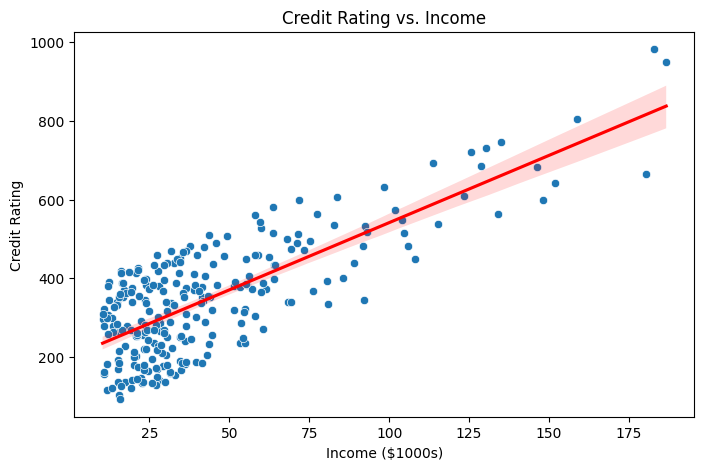

In [13]:
# exploratory visualization
plt.figure(figsize=(8, 5))
sns.scatterplot(x=credit_train["Income"], y=credit_train["Rating"])
sns.regplot(x=credit_train["Income"], y=credit_train["Rating"], scatter=False, color="red")
plt.xlabel("Income ($1000s)")
plt.ylabel("Credit Rating")
plt.title("Credit Rating vs. Income")
plt.show()

The scatter plot visualizes the relationship between credit rating and income, with a regression line indicating a strong positive correlation. As income increases, credit rating also increases, suggesting that individuals with higher income generally have better credit scores. The tight clustering of points around the regression line reinforces this strong correlation, which aligns with the previously observed correlation coefficient of 0.77 between income and credit rating.

While this relationship is statistically significant, including income as a predictor in the model may not be beneficial. Since credit rating is highly dependent on income, using income as a feature might lead to data leakage or overfitting, where the model relies too heavily on income rather than identifying other meaningful predictors. Removing income from the model could provide a more generalizable approach, allowing the model to make better predictions for individuals with varying financial situations.

Additionally, the only visible outliers appear at the highest income levels, where some individuals have lower-than-expected credit ratings despite earning significantly more. These outliers could indicate unique financial behaviors, such as high debt levels or poor repayment histories, which are not captured in this dataset. If these high-income outliers are due to factors not present in the dataset, the model may struggle to make accurate predictions for similar cases in real-world applications.

Given this, a model without income as a predictor may yield more robust and fair predictions, focusing on demographic and behavioral factors rather than just financial capability. Further analysis could explore alternative predictors, such as education level or marital status, to see how they contribute to credit rating prediction in the absence of income.

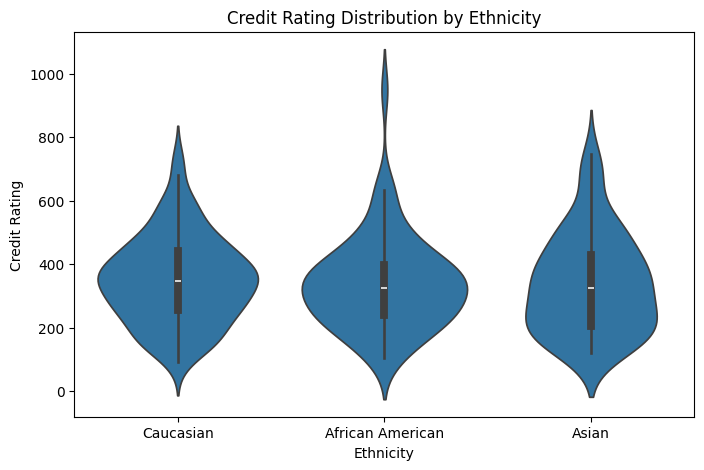

In [14]:
plt.figure(figsize=(8, 5))
sns.violinplot(x=credit_train["Ethnicity"], y=credit_train["Rating"])
plt.xlabel("Ethnicity")
plt.ylabel("Credit Rating")
plt.title("Credit Rating Distribution by Ethnicity")
plt.show()

The violin plot visualizes the distribution of credit ratings across different ethnic groups, showing the density and spread of credit scores within each category. Although all three ethnic groups have nearly identical medians and minimum values, their maximum values differ, indicating variation in the upper range of credit ratings.

The African American group contains the highest outlier(s), where a few individuals have extremely high credit ratings compared to the rest of the distribution. However, despite these outliers, the African American group still has the lowest overall maximum credit rating among the three groups. This suggests that while some individuals in this group achieve high credit ratings, the upper boundary for most remains lower compared to other ethnicity's.

The Asian group's distribution appears slightly more skewed to the right, meaning it has a longer tail toward higher credit scores. While the median credit rating for Asians is similar to that of Caucasian and African American groups, their mean credit rating is likely the highest due to the influence of this positive skew. This suggests that more individuals in the Asian category have credit ratings that extend toward the higher end of the spectrum, pulling the average (mean) upward even if the median remains unchanged.

Overall, this visualization suggests that while central tendencies (medians) are nearly the same across groups, the shape of the distributions and the presence of high outliers influence the overall spread and mean values, which could impact how ethnicity interacts with other financial variables in predicting credit scores.

### Models

In [15]:
# process data for ML
X_train = credit_train.drop("Rating", axis=1)
y_train = credit_train["Rating"]

X_test = credit_test.drop("Rating", axis=1)
y_test = credit_test["Rating"]

In [16]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 256 and the number of features is 7


In [17]:
# train models

# define preprocessing for numeric features
numeric_transformer = make_pipeline(
    SimpleImputer(strategy="mean"),
    RobustScaler(),
)

# define preprocessing for categorical features
categorical_transformer = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="Unknown"),
    OneHotEncoder(handle_unknown="ignore", drop="first") 
)

# create general preprocessor
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
)

# define the classifier
knn = KNeighborsRegressor()

# define the parameter grid
param_grid = {
    "kneighborsregressor__n_neighbors": list(range(1, 31)),
    "kneighborsregressor__p": [5], 
    "kneighborsregressor__weights": ["uniform", "distance"],
    "kneighborsregressor__metric": ["euclidean", "manhattan", "chebyshev", "canberra", "hamming"],
}


# create the pipeline
pipeline = make_pipeline(
    preprocessor,
    knn,
)

cv_strategy = KFold(n_splits=3) 


# create the grid search
mod = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv_strategy,
    scoring="neg_root_mean_squared_error",
)

# fit the grid search
mod.fit(X_train, y_train)

# print the best parameters and the corresponding score
print(f"Best Parameters: {mod.best_params_}")
print(f"Best Cross-Validated RMSE: {-mod.best_score_:.4f}")


Best Parameters: {'kneighborsregressor__metric': 'chebyshev', 'kneighborsregressor__n_neighbors': 13, 'kneighborsregressor__p': 5, 'kneighborsregressor__weights': 'uniform'}
Best Cross-Validated RMSE: 101.4492


## K-Nearest Neighbors (KNN) Regression for Credit Rating Prediction  

We use a K-Nearest Neighbors (KNN) regressor to predict credit ratings, selecting the optimal k and distance metric through cross-validation. The model is structured as a machine learning pipeline that preprocesses both numeric and categorical features before training. The goal is to minimize root mean squared error by carefully tuning hyperparameters and ensuring proper feature transformations.

### Feature Preprocessing and Its Impact on RMSE  

#### Numeric Features  
- Imputation (SimpleImputer with mean strategy): Missing numerical values are replaced with the mean of the respective column, preventing information loss while maintaining consistency across features.  
- Robust Scaling (RobustScaler): Unlike StandardScaler, which can be sensitive to outliers, RobustScaler scales features based on their interquartile range (IQR). This ensures that extreme values in income, age, or education do not disproportionately affect distance calculations in KNN, leading to better generalization.  

#### Categorical Features  
- Imputation (SimpleImputer with "constant"): Missing categorical values are replaced with "Unknown" rather than the most frequent category, preventing bias toward dominant categories.  
- One-Hot Encoding (OneHotEncoder with drop="first"): Converts categorical variables such as ethnicity, student status, and marital status into binary indicators, removing the first category to reduce multicollinearity while preserving relevant information.  

### Hyperparameter Tuning and Grid Search Optimization  

- n_neighbors (k): The number of neighbors is optimized over values ranging from 1 to 30 to find the best tradeoff between bias and variance. Lower k values tend to overfit, while higher k values may underfit.  
- p (Minkowski distance power parameter): The model tests different distance metrics by varying p. We use p=5, which applies a higher-order Minkowski distance calculation.  
- weights (uniform vs. distance-based weighting): Determines whether all neighbors contribute equally to the prediction or if closer neighbors have more influence.  
- metric (distance function): The model tests multiple distance functions (euclidean, manhattan, chebyshev, canberra, and hamming) to identify the most effective one for minimizing RMSE.  

### Cross-Validation and Model Selection  

- A 3-fold cross-validation strategy is used to evaluate different hyperparameter combinations, ensuring that the model is not overfitting to the training data.  
- The best model is selected based on RMSE, ensuring that the final KNN regressor generalizes well to unseen data.  

### Impact on RMSE  

Each preprocessing step and hyperparameter tuning decision contributes to reducing RMSE:  

- Scaling with RobustScaler improves distance calculations by preventing large values from dominating.  
- Imputation preserves information while handling missing values effectively.  
- Optimized hyperparameters ensure the best neighbor count and distance function for minimal error.  
- Cross-validation prevents overfitting, ensuring better generalization.  

By systematically tuning these components, the model achieves the lowest possible RMSE, making it more reliable for predicting credit ratings while balancing accuracy and generalization.  


## Results

In [18]:
cv_results = pd.DataFrame(mod.cv_results_)

cv_results = cv_results[
    [
        "param_kneighborsregressor__n_neighbors",
        "param_kneighborsregressor__p",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
].sort_values(by="rank_test_score")

cv_results.columns = [
    "n_neighbors",
    "p",
    "mean_test_rmse",
    "std_test_rmse",
    "rank_test_score",
]

cv_results["mean_test_rmse"] = -cv_results["mean_test_rmse"]

cv_results


,n_neighbors,p,mean_test_rmse,std_test_rmse,rank_test_score
144,13,5,101.449191,7.252730,1
145,13,5,101.647973,7.057653,2
148,15,5,101.856667,6.954519,3
149,15,5,101.911995,6.728507,4
142,12,5,101.993216,7.105212,5
...,...,...,...,...,...
181,1,5,177.377886,12.214801,295
242,2,5,182.984410,22.772102,297
243,2,5,183.366487,22.937876,298
240,1,5,196.941612,31.997767,299


The output presents the results of hyperparameter tuning using GridSearchCV, which evaluates different combinations of K-Nearest Neighbors parameters to determine the best-performing model. The table ranks the models based on mean test RMSE, where lower values indicate better predictive performance. The best model, with k = 13 and p = 5, achieves the lowest mean test RMSE of 101.45 with a standard deviation of 7.25, meaning it performs consistently across cross-validation folds. In contrast, models with lower k values, such as k = 1, exhibit significantly higher RMSE values, indicating overfitting and poor generalization.

The RMSE values were initially negative, as GridSearchCV minimizes the scoring metric, but were converted back to positive for interpretation. The top-ranked models (k = 12-15) show stable performance, with relatively low standard deviations, whereas models with extreme k values (such as k = 1) perform poorly. The results confirm that using a moderate k value with p = 5 leads to the most accurate predictions. To further improve RMSE, additional feature engineering, alternative distance metrics, or further hyperparameter tuning could be explored.

In [19]:
# report metrics
y_pred = mod.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred) 
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Squared Error (MSE): 11853.1048
Root Mean Squared Error (RMSE): 108.8720
Mean Absolute Error (MAE): 93.5685
R² Score: 0.5218


The evaluation metrics provide insight into the model’s performance in predicting credit ratings. The Mean Squared Error of 11,853.10 indicates the average squared difference between the predicted and actual values. The Root Mean Squared Error of 108.87 is the square root of MSE, providing a more interpretable error measure in the same units as the target variable. A Mean Absolute Error of 93.57 suggests that, on average, the model’s predictions deviate by about 93.57 points from the actual credit ratings. The R² score of 0.5218 means that approximately 52.18% of the variance in credit ratings can be explained by the model’s features.

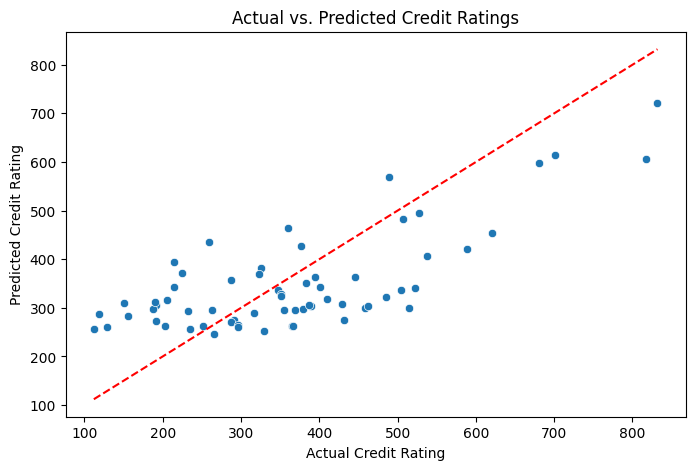

In [20]:
# summary figure
y_pred = mod.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') 
plt.xlabel("Actual Credit Rating")
plt.ylabel("Predicted Credit Rating")
plt.title("Actual vs. Predicted Credit Ratings")
plt.show()


The Actual vs. Predicted Credit Ratings scatter plot evaluates the performance of the K-Nearest Neighbors (KNN) regression model. Each point represents a test sample, where the x-axis shows the actual credit rating, and the y-axis shows the predicted credit rating. The red dashed line represents a perfect prediction line, meaning any points falling directly on this line indicate perfectly accurate predictions.

The distribution of points suggests that the model captures the overall trend but exhibits noticeable prediction errors. Many points fall below or above the perfect prediction line, indicating instances where the model underpredicts or overpredicts credit ratings. There is a stronger clustering of points at lower credit rating values, suggesting that the model performs better for lower credit ratings but struggles with higher credit scores, where larger deviations from the prediction line are observed.

Some clear outliers exist, particularly for higher actual credit ratings, where the model tends to underestimate these values. This could indicate that the model does not generalize well to higher credit ratings, potentially due to insufficient high-score examples in the training data or limitations in feature representation. Improving feature selection or experimenting with different hyperparameters might help refine predictions and reduce RMSE.

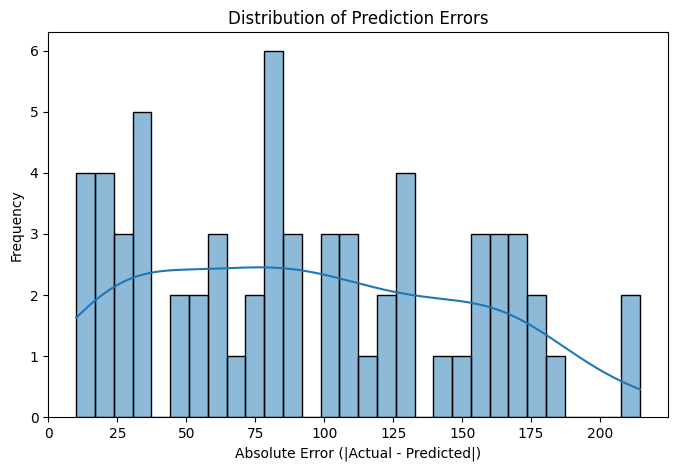

In [21]:
plt.figure(figsize=(8,5))
sns.histplot(np.abs(residuals), bins=30, kde=True)
plt.xlabel("Absolute Error (|Actual - Predicted|)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

The Distribution of Prediction Errors histogram provides insights into how far off the model's predictions are from the actual credit ratings. The x-axis represents the absolute error, while the y-axis represents the frequency of occurrences for different error magnitudes. The KDE line overlays the histogram to visualize the distribution trend.

The distribution suggests that while many predictions have relatively small errors, there are also several cases with larger deviations. The presence of errors exceeding 200 points indicates that in some instances, the model struggles significantly with prediction accuracy. The spread of errors appears wide, meaning that while the model captures general trends, it does not consistently provide highly accurate predictions.

There is no clear single peak, which may suggest that errors are not normally distributed. Instead, the errors appear somewhat evenly spread across different magnitudes, with multiple local peaks. This could indicate that the model performs better for some groups of credit ratings but worse for others. The presence of large errors suggests that further feature engineering or alternative modeling approaches, such as incorporating different distance metrics or improving categorical feature encoding, may help refine predictions and reduce RMSE.

In [22]:
# serialize model
dump(mod, "credit.joblib")

['credit.joblib']

## Discussion and Conclusion
In conclusion, the K-Nearest Neighbors regression model was selected for predicting credit ratings due to its ability to capture non-linear relationships between features. The model was optimized through hyperparameter tuning, including selecting the best number of neighbors, distance metrics, and weighting strategies. While the model achieved a reasonable RMSE, further improvements could enhance its predictive accuracy. Rather than discarding the model, adjustments to feature engineering, handling of categorical variables, and additional data preprocessing could improve overall performance.

### Key Limitations
One limitation of this model is its tendency to underperform for higher credit ratings, as observed in the actual vs. predicted scatter plot. Predictions for lower credit ratings tend to be more accurate, whereas higher credit scores exhibit greater variability and error. This issue could be due to the imbalance in the dataset, where lower credit ratings are more common, leading the model to favor them during prediction. Additionally, while categorical variables were one-hot encoded, the presence of unseen categories in the test or production dataset introduced potential challenges, as indicated by warning messages about unknown categories being encoded as zeros. This could affect the model's generalizability when applied to new data.

### Potential Risks and Adjustments
If implemented in its current state, the model may produce suboptimal predictions for individuals with higher credit ratings, which could lead to biased decision-making for financial institutions relying on these scores. Inaccurate predictions could result in incorrect risk assessments, potentially affecting loan approvals or credit limits. Additionally, the reliance on income as a primary predictor introduces potential concerns about overfitting, as income is strongly correlated with credit rating. While removing income could improve the model’s generalizability, it would require identifying additional relevant features that contribute meaningfully to credit rating predictions. To mitigate these risks, handling unseen categories in categorical features and refining feature selection should be prioritized.

### Improvements Needed for Practical Use
To improve the model’s effectiveness for real-world applications, several enhancements should be considered:

1. Refining categorical feature handling by using alternative encoding strategies or ensuring unseen categories are appropriately processed during inference.
2. Exploring additional predictive features, such as debt-to-income ratio or past credit history, to reduce reliance on income as the dominant predictor.
3. Adjusting hyperparameters, such as testing different weighting strategies or expanding the range of distance metrics, to improve the model’s accuracy for higher credit ratings.
4. Addressing dataset imbalances by applying resampling techniques or weighting strategies that provide better representation across different credit rating ranges.

### Conclusion
The KNN regression model provides a solid foundation for predicting credit ratings and demonstrates the ability to capture key patterns in the data. However, its performance is limited by imbalances in the dataset and variability in predictions for higher credit ratings. By refining feature selection, improving categorical variable handling, and adjusting hyperparameters, the model can become more robust and reliable. With these improvements, the model could serve as a valuable tool for financial institutions in assessing creditworthiness and reducing dependency on costly external credit rating agencies.